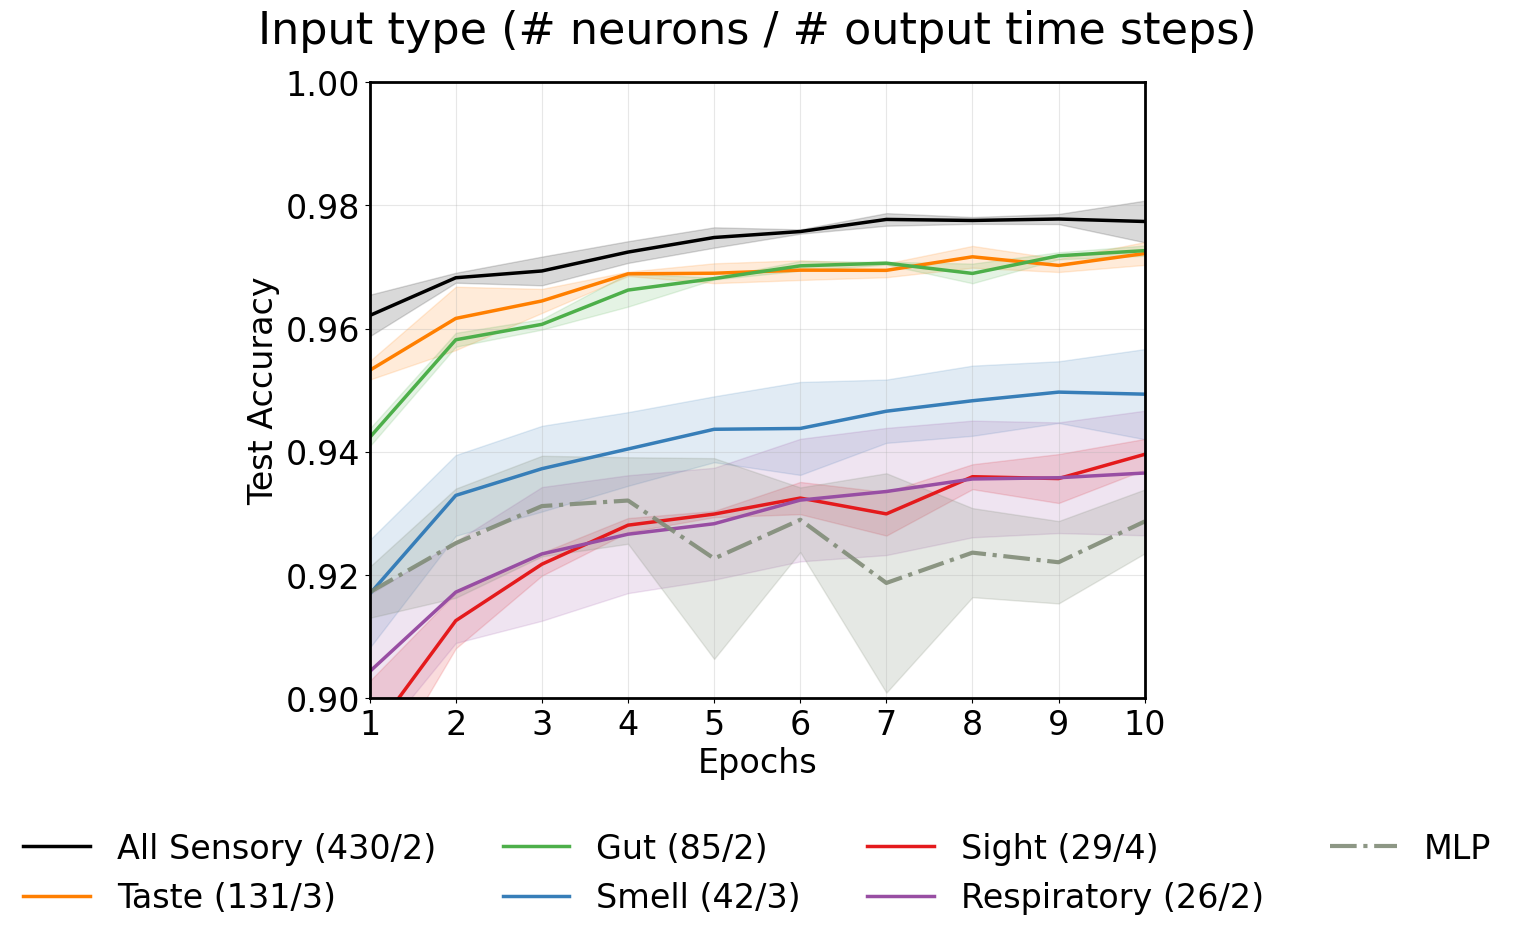

In [141]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Get the project root directory
try:
    # When running as a script
    PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
except NameError:
    # When running in a notebook
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Configuration
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
SELECTED_SAMPLE = "5%"  # Assuming this matches plot_metrics.ipynb

# Define colors for sensory types - these are the base labels
SENSORY_COLORS = {
    "Sight": "#E41A1C",            # Red
    "Smell": "#377EB8",         # Blue
    "Gut": "#4DAF4A",               # Green
    "Respiratory": "#984EA3",       # Purple
    "Taste": "#FF7F00", # Orange
    "All Sensory": "#000000",        # Black
    "MLP": "#818C78", 
    "CNN": "#9694FF"
}

def load_sensory_comparison_results():
    """
    Load the results for different sensory input types.
    """
    data = {}
    
    # Map of experiment names to sensory types for better labeling
    # This maps to the exact experiment names in the result files
    experiment_to_type = {
        "Unlearnable_Visual_DPU": "Sight",
        "Unlearnable_Olfactory_DPU": "Smell",
        "Unlearnable_Gut_DPU": "Gut",
        "Unlearnable_Respiratory_DPU": "Respiratory",
        "Unlearnable_Gustatory_DPU": "Taste",
        "Unlearnable_All_Sensory_DPU": "All Sensory",
        "MultiSensory_Temporal_Fusion": "Multi-Sensory-Temporal",
        "Unlearnable_Twohidden_MLP": "MLP",
        "CNN_Model": "CNN"
    }
    
    # Count neurons for each sensory type to enhance the labels
    neuron_counts = {}
    
    for fname in os.listdir(RESULTS_DIR):
        # Check if file matches the new format (e.g., Unlearnable_Visual_DPU_trial1.signed.pkl)
        for exp_name, sensory_type in experiment_to_type.items():
            if re.match(f"^{exp_name}.*(?<!fewshot)\\.signed\\.pkl$", fname) and "fewshot" not in fname:
                with open(os.path.join(RESULTS_DIR, fname), "rb") as f:
                    results = pickle.load(f)
                    
                    # Store the results using the base sensory type as key
                    data.setdefault(sensory_type, []).append(results)
                    
                    # Extract neuron count if available
                    if isinstance(results, dict) and 'sensory_dim' in results:
                        neuron_counts[sensory_type] = results['sensory_dim']
    
    # Now enhance the labels with neuron counts if available
    enhanced_data = {}
    for sensory_type, results in data.items():
        if sensory_type in neuron_counts:
            enhanced_label = f"{sensory_type} ({neuron_counts[sensory_type]} neurons)"
        else:
            enhanced_label = sensory_type
        enhanced_data[enhanced_label] = results
    
    return enhanced_data

def plot_sensory_comparison():
    """
    Plot performance comparison across different sensory input types.
    """
    plt.figure(figsize=(10, 8))
    
    data = load_sensory_comparison_results()
    
    # Custom legend names mapping with simplified format
    custom_legend_names = {
        "Sight": "Sight (29/4)",
        "Smell": "Smell (42/3)",
        "Gut": "Gut (85/2)",
        "Respiratory": "Respiratory (26/2)",
        "Taste": "Taste (131/3)",
        "All Sensory": "All Sensory (430/2)",
        "Unlearnable_Twohidden_MLP": "MLP",
        "CNN_Model": "CNN"
    }
    
    # Define custom order for plotting
    custom_order = [
        "All Sensory",
        "Taste",
        "Gut",
        "Smell",
        "Sight",
        "Respiratory",
        "MLP"
    ]
    
    # Sort data according to custom order
    sorted_data = sorted(data.items(), 
                        key=lambda x: custom_order.index(x[0].split(" (")[0]) 
                        if x[0].split(" (")[0] in custom_order 
                        else len(custom_order))
    
    # Plot each sensory type
    for i, (sensory_label, results_list) in enumerate(sorted_data):
        # Extract the base sensory type from the enhanced label (e.g., "Visual (123 neurons)" -> "Visual")
        base_sensory_type = sensory_label.split(" (")[0] 
        
        # Skip multi-sensory
        if base_sensory_type == "Multi-Sensory-Temporal":
            continue
            
        # Use custom legend name if available, otherwise use the original label
        legend_name = custom_legend_names.get(base_sensory_type, sensory_label)
        
        # Extract accuracy values from each result dictionary
        acc_values = []
        for result in results_list:
            if 'test_acc' in result:
                acc_values.append(result['test_acc'][1:11])  # Only take epochs 1-10
            elif 'epoch_test_acc' in result:
                acc_values.append(result['epoch_test_acc'][1:11])  # Only take epochs 1-10
            else:
                print(f"Warning: No accuracy data found in result for {sensory_label}")
                continue
        
        if not acc_values:
            print(f"Warning: No valid accuracy data found for {sensory_label}")
            continue
            
        # Convert to numpy array
        acc_matrix = np.array(acc_values)
        
        # Calculate mean and standard deviation across trials
        mean = np.mean(acc_matrix, axis=0)
        std = np.std(acc_matrix, axis=0, ddof=1)
        
        # Use epochs 1-10 as x-axis
        x = np.arange(1, 11)  # Only epochs 1-10
        
        # Get color based on the base sensory type
        color = SENSORY_COLORS.get(base_sensory_type)
        if color is None:
            # Fallback to default colors if not found
            color = plt.cm.tab10(i % 10)
        
        # Plot mean line
        plt.plot(
            x, mean,
            color=color,
            label=legend_name,  # Use custom legend name
            linewidth=3.0 if base_sensory_type == 'MLP' and base_sensory_type == 'CNN' else 2.5,  # Thicker line for MLP
            linestyle='-' if base_sensory_type != 'MLP' and base_sensory_type != 'CNN' else '--',  # Use dash-dot line for MLP
            alpha=1.0 if base_sensory_type != 'MLP' and base_sensory_type != 'CNN' else 0.9  # Slightly reduce opacity for MLP
        )
        
        # Plot standard deviation as shaded area
        plt.fill_between(
            x, mean - std, mean + std,
            color=color,
            alpha=0.15 if base_sensory_type != 'MLP' and base_sensory_type != 'CNN' else 0.2  # Increase opacity for MLP error band
        )
    
    plt.title("Input type (# neurons / # output time steps)", fontsize=32, pad=28)
    plt.xlabel("Epochs", fontsize=24)
    plt.ylabel("Test Accuracy", fontsize=24)
    plt.xlim(1, 10)  # Only show epochs 1-10
    plt.ylim(0.9, 1.0)  # Set y-axis range to 0.9-1.0 for better visualization
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    legend = plt.legend(
        loc='lower center',           
        bbox_to_anchor=(0.5, -0.4),   
        ncol=4,                    
        frameon=False,
        fontsize=24,
    )
    
    # Create figures directory if it doesn't exist
    figures_dir = os.path.join(PROJECT_ROOT, "plotting", "figures")
    os.makedirs(figures_dir, exist_ok=True)
    
    plt.savefig(os.path.join(figures_dir, "sensory_comparison.pdf"), bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    plot_sensory_comparison() 